# Predict Student Performance from Game Play
##### Kaggle link: https://www.kaggle.com/competitions/predict-student-performance-from-game-play


### Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import math
import seaborn as sns
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import sklearn
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(23)
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Loading the datasets


In [2]:
dataset = pd.DataFrame(pd.read_csv("train.csv"))
train_labels = pd.DataFrame(pd.read_csv("train_labels.csv"))

#### I have taken small amount of data since my Computer was crashing, by Dividing the dataset through the session id, i have taken 5% of total unique Session_id.

In [3]:
print("Data set shape",dataset.shape)
total_no_session=len(dataset['session_id'].unique())
session_list=dataset['session_id'].unique()
sample_size_session=math.floor(total_no_session*0.05)
sample_session_list=session_list[:sample_size_session]
dataset=dataset[dataset['session_id'].isin(sample_session_list)]
print("Sampled Data set shape",dataset.shape)

Data set shape (26296946, 20)
Sampled Data set shape (1323654, 20)


#### Saving The sample dataset to csv, incase of reading the data again.

In [4]:
dataset.to_csv("sample.csv", sep='\t')

In [5]:
print("Train Labels shape",train_labels.shape)
train_labels.head()

Train Labels shape (424116, 2)


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1


In [6]:
#splitting "_q"  to get seession_id and the question number
train_labels[['session_id','q']] = train_labels['session_id'].str.split('_q',expand=True)

In [7]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424116 entries, 0 to 424115
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   session_id  424116 non-null  object
 1   correct     424116 non-null  int64 
 2   q           424116 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.7+ MB


In [8]:
#Converting to str to compare in train_labels data frame
str_sample_session_list = [str(num) for num in sample_session_list]
#for the train labels also we are just taking 5% of same session_id
train_labels[train_labels['session_id'].isin(str_sample_session_list)]

,session_id,correct,q
0,20090312431273200,1,1
1,20090312433251036,0,1
2,20090312455206810,1,1
3,20090313091715820,0,1
4,20090313571836404,1,1
...,...,...,...
401727,20100514244972480,1,18
401728,20100514250029070,1,18
401729,20100514275123884,1,18
401730,20100514334097228,1,18


In [9]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424116 entries, 0 to 424115
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   session_id  424116 non-null  object
 1   correct     424116 non-null  int64 
 2   q           424116 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.7+ MB


## Cleaning the data

In [10]:
#Trying to remove columns which has more than 60% of null values
dataset.columns[(dataset.isna().sum()/len(dataset))>0.6]

Index(['page', 'hover_duration', 'text', 'text_fqid'], dtype='object')

In [11]:
del dataset['page']
del dataset['hover_duration']
del dataset['text']
del dataset['text_fqid']

In [12]:
dataset.isna().sum()

session_id            0
index                 0
elapsed_time          0
event_name            0
name                  0
level                 0
room_coor_x      115013
room_coor_y      115013
screen_coor_x    115013
screen_coor_y    115013
fqid             411336
room_fqid             0
fullscreen            0
hq                    0
music                 0
level_group           0
dtype: int64

In [13]:
# Filling the Nan values
dataset['room_coor_x'].fillna(method="ffill", inplace= True)
dataset['room_coor_y'].fillna(method="ffill", inplace= True)
dataset['screen_coor_x'].fillna(method="ffill", inplace= True)
dataset['screen_coor_y'].fillna(method="ffill", inplace= True)
dataset['fqid'].fillna(method="ffill", inplace= True)

In [15]:
#Encoding the categorical columns
label_encoder = preprocessing.LabelEncoder()

for i in categorical_cols:
    dataset[i]= label_encoder.fit_transform(dataset[i])
dataset.head()

,session_id,index,elapsed_time,event_name,name,level,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,fqid,room_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,1,0,0,-413.991405,-159.314686,380.0,494.0,40,7,0,0,1,0
1,20090312431273200,1,1323,10,0,0,-413.991405,-159.314686,380.0,494.0,37,7,0,0,1,0
2,20090312431273200,2,831,10,0,0,-413.991405,-159.314686,380.0,494.0,37,7,0,0,1,0
3,20090312431273200,3,1147,10,0,0,-413.991405,-159.314686,380.0,494.0,37,7,0,0,1,0
4,20090312431273200,4,1863,10,0,0,-412.991405,-159.314686,381.0,494.0,37,7,0,0,1,0


In [16]:
list(label_encoder.inverse_transform([0, 1, 2]))

['0-4', '13-22', '5-12']

In [17]:
#Merging the 2 csv file data into one, based on session_id
dataset['session_id']=dataset['session_id'].astype(str)
datasets=pd.merge(dataset,train_labels,on='session_id',how='inner')
datasets.drop(['session_id'],inplace=True,axis=1)

In [18]:
datasets.head()

,index,elapsed_time,event_name,name,level,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,fqid,room_fqid,fullscreen,hq,music,level_group,correct,q
0,0,0,1,0,0,-413.991405,-159.314686,380.0,494.0,40,7,0,0,1,0,1,1
1,0,0,1,0,0,-413.991405,-159.314686,380.0,494.0,40,7,0,0,1,0,1,2
2,0,0,1,0,0,-413.991405,-159.314686,380.0,494.0,40,7,0,0,1,0,1,3
3,0,0,1,0,0,-413.991405,-159.314686,380.0,494.0,40,7,0,0,1,0,1,4
4,0,0,1,0,0,-413.991405,-159.314686,380.0,494.0,40,7,0,0,1,0,1,5


In [19]:
#saving the dataset, Incase of emergencies
datasets.to_csv("sample_cleaned.csv", sep='\t')

In [21]:
datasets=pd.read_csv("sample_cleaned.csv", sep='\t')

In [22]:
datasets.drop(['Unnamed: 0','index'],inplace=True,axis=1)
# datasets=datasets.reset_index()

In [23]:
datasets.head()

,elapsed_time,event_name,name,level,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,fqid,room_fqid,fullscreen,hq,music,level_group,correct,q
0,0,1,0,0,-413.991405,-159.314686,380.0,494.0,40,7,0,0,1,0,1,1
1,0,1,0,0,-413.991405,-159.314686,380.0,494.0,40,7,0,0,1,0,1,2
2,0,1,0,0,-413.991405,-159.314686,380.0,494.0,40,7,0,0,1,0,1,3
3,0,1,0,0,-413.991405,-159.314686,380.0,494.0,40,7,0,0,1,0,1,4
4,0,1,0,0,-413.991405,-159.314686,380.0,494.0,40,7,0,0,1,0,1,5


In [27]:
#getting columns that have categorical data and numerical data
categorical_cols = list(datasets.select_dtypes(include='object'))
numerical_cols=list(datasets.select_dtypes(exclude='object'))

### Data Visualization

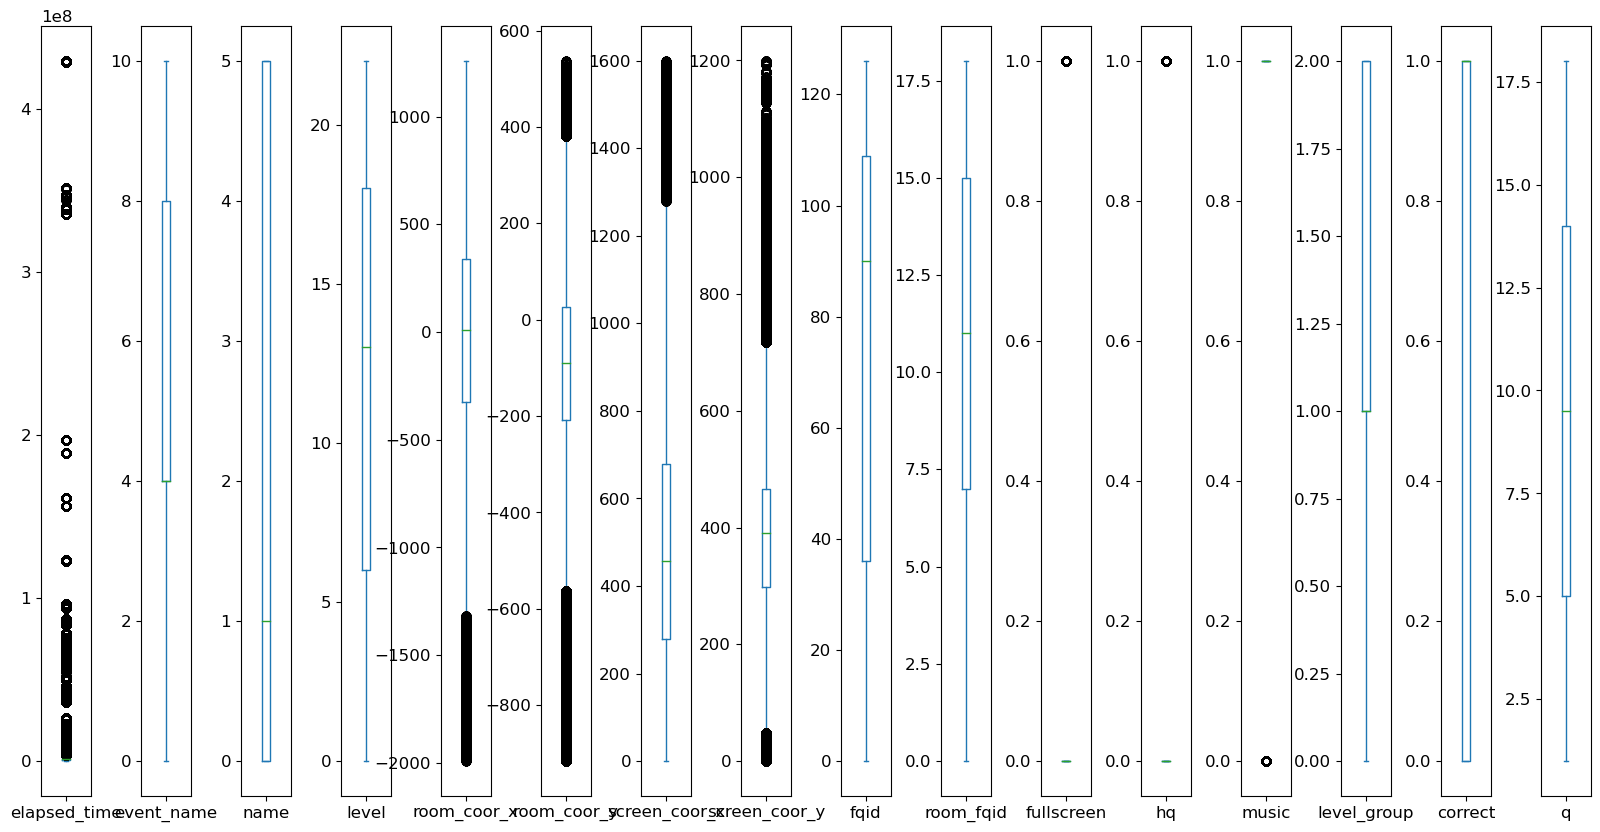

In [28]:
datasets[numerical_cols].plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(20, 10)
)

# increase spacing between subplots
plt.subplots_adjust(wspace=1) 
plt.show()

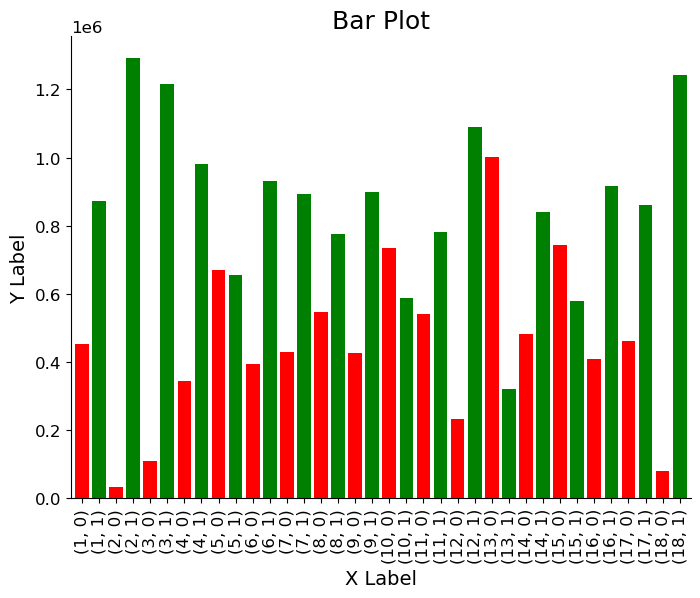

In [29]:
df = datasets[["q","correct"]]
df1= df.groupby(['q','correct']).value_counts()
colors = ["red", "green",]
fig, ax = plt.subplots(figsize=(8, 6))
ax = df1.plot(kind='bar',width=0.8, color=colors * (len(df.columns) // len(colors) + 1))
# ax.patches[0].set_facecolor('red')  # set the color of the first bar to red
# ax.patches[1].set_facecolor('green')  # set the color of the second bar to green
ax.set_title('Bar Plot', fontsize=18)
ax.set_xlabel('X Label', fontsize=14)
ax.set_ylabel('Y Label', fontsize=14)

# remove unnecessary spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# adjust the tick label font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:>

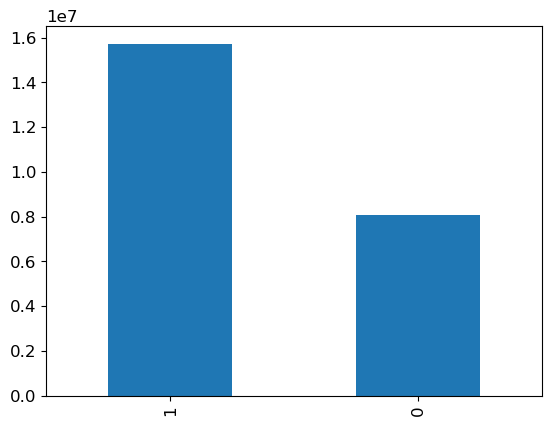

In [30]:
df['correct'].value_counts().plot(kind='bar')

### Train, Validate, Test data split

In [31]:
X=datasets.drop('correct',axis=1)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, datasets.correct, random_state=23)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=23)

In [32]:
#Function To build Input pipeline: Saves chunks of data into 10 or n parts as csv file
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "files")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")
    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

In [33]:
X_train

,elapsed_time,event_name,name,level,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,fqid,room_fqid,fullscreen,hq,music,level_group,q
7020204,2868066,4,5,18,-106.213083,-731.482751,580.0,608.0,123,18,0,0,1,1,7
1346827,1861531,7,0,15,-267.746834,-375.146135,399.0,560.0,29,11,0,1,1,1,14
18324232,353205,3,0,9,763.584260,-16.329277,760.0,308.0,120,1,1,0,1,2,17
13458115,945518,6,0,15,-38.074793,-272.559490,540.0,497.0,29,11,0,0,1,1,2
3731276,1699010,3,0,20,522.680583,-77.503641,819.0,398.0,113,4,0,0,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21875256,235496,4,5,3,-364.815255,-24.000000,553.0,354.0,119,15,1,0,1,0,1
2785935,163530,8,5,3,439.769038,-283.000000,450.0,613.0,70,15,0,0,1,0,4
17451292,7668376,4,5,17,-318.938909,-149.287147,97.0,410.0,99,11,1,1,1,1,5
14930125,1970968,6,0,21,382.725528,-160.244420,747.0,492.0,51,13,0,1,1,1,8


In [34]:
y_train

7020204     0
1346827     0
18324232    1
13458115    1
3731276     1
           ..
21875256    0
2785935     1
17451292    1
14930125    1
13847709    1
Name: correct, Length: 13401996, dtype: int64

In [35]:
#Saving the data into N parts
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = ['elapsed_time', 'event_name', 'name', 'level', 'room_coor_x',
       'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'fqid', 'room_fqid',
       'fullscreen', 'hq', 'music', 'level_group', 'q','correct']

header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

In [36]:
pd.read_csv(test_filepaths[1]).head()

,elapsed_time,event_name,name,level,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,fqid,room_fqid,fullscreen,hq,music,level_group,q,correct
0,605983.0,9.0,0.0,6.0,-42.057065,48.000000,299.0,282.0,64.0,12.0,0.0,0.0,1.0,2.0,6.0,0.0
1,9168673.0,4.0,5.0,7.0,-64.348501,118.000000,344.0,212.0,0.0,12.0,0.0,0.0,1.0,2.0,14.0,1.0
2,1300958.0,1.0,0.0,16.0,-998.089825,-294.079310,369.0,589.0,25.0,6.0,0.0,0.0,1.0,1.0,8.0,1.0
3,258685.0,10.0,0.0,6.0,-433.583562,-130.163035,490.0,427.0,37.0,8.0,0.0,0.0,1.0,2.0,8.0,0.0
4,2776147.0,4.0,5.0,20.0,-72.214983,-245.560821,384.0,499.0,98.0,10.0,1.0,0.0,1.0,1.0,12.0,1.0


In [37]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5, 
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1), 
        cycle_length=n_readers,
        num_parallel_calls=n_read_threads)
    
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size) 
    
    return dataset.prefetch(1)

In [38]:
train_set = csv_reader_dataset(train_filepaths, repeat=None)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [39]:
X_train.shape

(13401996, 15)

In [40]:
# create a scaler object
scaler = StandardScaler()

# fit the scaler to the data
scaler.fit(X_train)

# apply the scaler to the data
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [41]:
num_features=15
batch_size=32

In [42]:
keras.backend.clear_session()
np.random.seed(23)
tf.random.set_seed(23)

## Baseline models
Even Though Data given is Time Series, But in the end we have to predict if the students(Session_id) answered the 18 questions Correctly or not. Hence it becomes a Classification problem and not time series problem
<br>Hence, I have Built 3 Baseline models:<br>
<ol>1. Multi Layered Pereceptron (MLP) </ol>
<ol>2. Convolution Neural Network (CNN)</ol>
<ol>3. Recurrent Neural network (RNN)</ol>

In [43]:
#Since target 1(answered correct) is Almost twice of target 0(answered Incorrect), 
#Due to imbalace In dataset we are using F1 Score
def f1(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.round(y_pred), tf.float32)
    return tf.py_function(f1_score, (y_true, y_pred), tf.float32)

In [44]:
#mlp model
mlp_model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(num_features,)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
optimizer = keras.optimizers.Adam(learning_rate=0.01)
mlp_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',f1])

mlp_history = mlp_model.fit(X_train,y_train, 
                    validation_data=(X_valid,y_valid),
                    epochs=5, batch_size=512)

Epoch 1/5
26176/26176 [==============================] - 66s 2ms/step - loss: 0.5580 - accuracy: 0.6997 - f1: 0.7986 - val_loss: 0.5510 - val_accuracy: 0.7054 - val_f1: 0.7963
Epoch 2/5
26176/26176 [==============================] - 62s 2ms/step - loss: 0.5480 - accuracy: 0.7085 - f1: 0.8022 - val_loss: 0.5457 - val_accuracy: 0.7099 - val_f1: 0.8018
Epoch 3/5
26176/26176 [==============================] - 63s 2ms/step - loss: 0.5461 - accuracy: 0.7104 - f1: 0.8021 - val_loss: 0.5447 - val_accuracy: 0.7111 - val_f1: 0.8001
Epoch 4/5
26176/26176 [==============================] - 64s 2ms/step - loss: 0.5452 - accuracy: 0.7113 - f1: 0.8025 - val_loss: 0.5452 - val_accuracy: 0.7103 - val_f1: 0.7969
Epoch 5/5
26176/26176 [==============================] - 70s 3ms/step - loss: 0.5447 - accuracy: 0.7118 - f1: 0.8028 - val_loss: 0.5442 - val_accuracy: 0.7114 - val_f1: 0.7996


In [45]:
mlp_model.evaluate(X_test,y_test)

186139/186139 [==============================] - 262s 1ms/step - loss: 0.5443 - accuracy: 0.7110 - f1: 0.7959


[0.5443128347396851, 0.7110047340393066, 0.7958606481552124]

In [19]:
#CNN model
cnn_model = keras.Sequential([
    keras.layers.Reshape((num_features, 1), input_shape=(num_features,)),
    keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.01)
cnn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',f1])

# Train the model
cnn_history=cnn_model.fit(X_train, y_train, epochs=5, batch_size=512, validation_data=(X_valid, y_valid))

Epoch 1/5
26176/26176 [==============================] - 95s 4ms/step - loss: 50.8693 - accuracy: 0.6570 - f1: 0.7875 - val_loss: 0.6408 - val_accuracy: 0.6604 - val_f1: 0.7953
Epoch 2/5
26176/26176 [==============================] - 97s 4ms/step - loss: 8.3830 - accuracy: 0.6601 - f1: 0.7948 - val_loss: 0.6407 - val_accuracy: 0.6604 - val_f1: 0.7953
Epoch 3/5
26176/26176 [==============================] - 101s 4ms/step - loss: 0.6408 - accuracy: 0.6604 - f1: 0.7953 - val_loss: 0.6407 - val_accuracy: 0.6604 - val_f1: 0.7953
Epoch 4/5
26176/26176 [==============================] - 110s 4ms/step - loss: 0.6408 - accuracy: 0.6604 - f1: 0.7953 - val_loss: 0.6408 - val_accuracy: 0.6604 - val_f1: 0.7953
Epoch 5/5
26176/26176 [==============================] - 120s 5ms/step - loss: 0.6408 - accuracy: 0.6604 - f1: 0.7953 - val_loss: 0.6409 - val_accuracy: 0.6604 - val_f1: 0.7953


In [20]:
cnn_model.evaluate(X_test,y_test)

186139/186139 [==============================] - 262s 1ms/step - loss: 0.6409 - accuracy: 0.6603 - f1: 0.7918


[0.6408503651618958, 0.6602999567985535, 0.7917505502700806]

In [21]:
#RNN model
rnn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(num_features)),
     tf.keras.layers.Reshape((-1, num_features)),
    tf.keras.layers.SimpleRNN(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')])
    
rnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),f1])

rnn_history=rnn_model.fit(X_train, y_train, epochs=5, batch_size=512, validation_data=(X_valid, y_valid))

Epoch 1/5
26176/26176 [==============================] - 69s 3ms/step - loss: 358.9131 - binary_accuracy: 0.6450 - f1: 0.7591 - val_loss: 0.6408 - val_binary_accuracy: 0.6604 - val_f1: 0.7953
Epoch 2/5
26176/26176 [==============================] - 67s 3ms/step - loss: 0.6711 - binary_accuracy: 0.6604 - f1: 0.7953 - val_loss: 0.6407 - val_binary_accuracy: 0.6604 - val_f1: 0.7953
Epoch 3/5
26176/26176 [==============================] - 71s 3ms/step - loss: 0.6408 - binary_accuracy: 0.6604 - f1: 0.7953 - val_loss: 0.6407 - val_binary_accuracy: 0.6604 - val_f1: 0.7953
Epoch 4/5
26176/26176 [==============================] - 71s 3ms/step - loss: 0.6408 - binary_accuracy: 0.6604 - f1: 0.7953 - val_loss: 0.6408 - val_binary_accuracy: 0.6604 - val_f1: 0.7953
Epoch 5/5
26176/26176 [==============================] - 71s 3ms/step - loss: 0.6408 - binary_accuracy: 0.6604 - f1: 0.7953 - val_loss: 0.6409 - val_binary_accuracy: 0.6604 - val_f1: 0.7953


In [22]:
rnn_model.evaluate(X_test,y_test)

186139/186139 [==============================] - 256s 1ms/step - loss: 0.6409 - binary_accuracy: 0.6603 - f1: 0.7918


[0.6408503651618958, 0.6602999567985535, 0.7917505502700806]

## Evaluation of 3 models:
<table border=1>
    <tr><th>Model</th><th>Accuracy</th><th>F1 Score</th></tr>
    <tr><th>MLP</th><td>0.6602999567985535</td><td>0.7917505502700806</td></tr>
    <tr><th>CNN</th><td>0.6602999567985535</td><td>0.7917505502700806</td></tr>
    <tr><th>RNN</th><td>0.6602999567985535</td><td>0.7917505502700806</td></tr>

In [5]:
class_count=datasets['correct'].value_counts()

minority_class = class_count.idxmin()
minority_class_count = class_count[minority_class]

majority_class = class_count.idxmax()
majority_class_count = class_count[majority_class]
# Sample the majority class to match the minority class count
majority_class_samples = datasets[datasets['correct'] == majority_class].sample(minority_class_count)

# Combine the minority class with the sampled majority class
balanced_df = pd.concat([datasets[datasets['correct'] == minority_class], majority_class_samples])

balanced_df['correct'].value_counts()

0    8092045
1    8092045
Name: correct, dtype: int64

##### Since all the models are giving same accuracy, To select the features again, we are using Decision Tree Regressor

In [6]:
datasets.shape

(23825772, 16)

In [27]:
X=datasets.drop('correct',axis=1)
Y=datasets['correct']

In [8]:
#using descision tree regressor to get the columns which impact the target variable most
dr=DecisionTreeRegressor()
dr.fit(X,Y)
zipped=list(zip(datasets.columns, dr.feature_importances_))
features_sorted=sorted(zipped, key=lambda x: x[1])
features_sorted

[('level_group', 0.002702983601203737),
 ('name', 0.003945690972200366),
 ('music', 0.010606844961929202),
 ('event_name', 0.011846876783843757),
 ('hq', 0.012172529446033855),
 ('fullscreen', 0.012266528442091024),
 ('room_fqid', 0.02249729847210044),
 ('fqid', 0.03214879173445342),
 ('level', 0.04367889174073267),
 ('screen_coor_y', 0.096227740214029),
 ('room_coor_y', 0.10419548576585934),
 ('room_coor_x', 0.11138880816437771),
 ('screen_coor_x', 0.12184128519226),
 ('correct', 0.17721693395619592),
 ('elapsed_time', 0.2372633105526897)]

In [20]:
### here we are selecting top 10 features based on the feature importance
cols=['elapsed_time',"screen_coor_x","room_coor_x",'room_coor_y','screen_coor_y','level','fqid','hq','fullscreen','event_name']
X=X[cols]

In [28]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, Y, random_state=23)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=23)

In [30]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [34]:
#Since all 3 models gave the same accuracy, im trying to improve MLP model by adding more layers, neurons, exponential decay
model= keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(15,)),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation='relu',kernel_initializer="he_normal"),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation='relu',kernel_initializer="he_normal"),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation='relu',kernel_initializer="he_normal"),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation='relu',kernel_initializer="he_normal"),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(16, activation='relu',kernel_initializer="he_normal"),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid')])

In [35]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 512)               8192      
                                                                 
 dropout_24 (Dropout)        (None, 512)               0         
                                                                 
 batch_normalization_24 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_29 (Dense)            (None, 256)               131328    
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_25 (Bat  (None, 256)              1024      
 chNormalization)                                     

In [41]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy',f1])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),batch_size=512,
                    callbacks=[early_stop])

Epoch 1/10
26176/26176 [==============================] - 716s 27ms/step - loss: 0.5402 - accuracy: 0.7152 - f1: 0.8066 - val_loss: 0.5316 - val_accuracy: 0.7189 - val_f1: 0.8098
Epoch 2/10
26176/26176 [==============================] - 589s 22ms/step - loss: 0.5391 - accuracy: 0.7157 - f1: 0.8069 - val_loss: 0.5305 - val_accuracy: 0.7202 - val_f1: 0.8099
Epoch 3/10
26176/26176 [==============================] - 624s 24ms/step - loss: 0.5379 - accuracy: 0.7167 - f1: 0.8072 - val_loss: 0.5310 - val_accuracy: 0.7212 - val_f1: 0.8077
Epoch 4/10
26176/26176 [==============================] - 640s 24ms/step - loss: 0.5369 - accuracy: 0.7171 - f1: 0.8073 - val_loss: 0.5277 - val_accuracy: 0.7217 - val_f1: 0.8111
Epoch 5/10
26176/26176 [==============================] - 616s 24ms/step - loss: 0.5362 - accuracy: 0.7175 - f1: 0.8075 - val_loss: 0.5266 - val_accuracy: 0.7225 - val_f1: 0.8106
Epoch 6/10
26176/26176 [==============================] - 652s 25ms/step - loss: 0.5353 - accuracy: 0.718

In [42]:
model.evaluate(X_test,y_test)

186139/186139 [==============================] - 741s 4ms/step - loss: 0.5240 - accuracy: 0.7234 - f1: 0.8113


[0.5239821672439575, 0.7233765125274658, 0.811265766620636]

#### The accuracy of MLP is increased from 0.6602 to 0.7234 and F1 score from 0.7917 to 0.8112 